<a href="https://colab.research.google.com/github/StephMcCallum/CHEM561/blob/main/HW5_DFT_Si.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Silicon-Based Materials

In this notebook, I adapted code from workbook 8 on carbon systems to look at silicon crystal structures. I used the implementation of the diamond phase to look at a silicon FCC structure. I looked at the convergence of the lattice parameter with the PBE pseudopotential. I looked at the effect of changing the k paramter. I also compared the band diagram to a computational source.

In [1]:
# @title Install qepy package  { display-mode: "form" }
!pip install qepy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Modules Setup { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
!pip install -q ase > /dev/null
from ase.build import bulk, graphene, stack
from ase.io import write
from ase import Atoms
from ase.visualize import view
from qepy.calculator import QEpyCalculator
import time

# Part 1 : Comparing two density functionals and finding convergence of lattice parameter
## Silicon PBE functional of diamond phase

In [4]:
def run_one(func):
  # @title Simulation Parameters  { display-mode: "form" }
  ecutwfc = 20  # @param {type:"number"}
  ecutrho = 200  # @param {type:"number"}
  conv_thr = 1e-6  # @param {type:"number"}
  functional = func
  phase = "diamond"  # @param ["diamond", "graphite", "graphene"]
  occupations = "fixed"  # @param ["smearing", "fixed"]
  kpoints = "8 8 8 0 0 0"  # @param {type:"string"} #What is this?

  if functional == "PBEsol":
      pseudopotential = "Si.pbesol-n-rrkjus_psl.1.0.0.UPF"
  elif functional == "PBE":
      pseudopotential = "Si.pbe-n-rrkjus_psl.1.0.0.UPF"

  qe_options = {
      '&control': {
          'calculation': "'scf'",
          'prefix': "'"+phase+"'",
          'pseudo_dir': "'/content/drive/MyDrive/pp/'",
      },
      '&system': {
          'ibrav': 0,
          'ecutwfc': ecutwfc,
          'ecutrho': ecutrho,
          'occupations': "'"+occupations+"'",
          'smearing': "'gaussian'",
          'degauss': 0.01,
      },
      '&electrons': {
          'conv_thr': conv_thr,
      },
      'atomic_species': ['Si 28.0855 '+pseudopotential],
      'k_points automatic': [kpoints],
  }

  # @title Generate and Visualize the System  { display-mode: "form" }
  show = 'reciprocal'  # @param ["direct", "reciprocal"]

  if phase == "graphite":
      a = 2.46   # in-plane lattice parameter (Å)
      c = 6.70   # c-axis (Å), ~ 2 × 3.35 Å interlayer spacing

      # Hexagonal cell vectors
      cell = [
          (a, 0.0, 0.0),
          (a/2, a*np.sqrt(3)/2, 0.0),
          (0.0, 0.0, c)
      ]

      # AB stacking (P6_3/mmc): 4 atoms per conventional hex cell
      # fractional coords: layer 1 (z=0):        (0,0,0), (1/3,1/3,0)
      #                     layer 2 (z=1/2):     (0,0,1/2), (2/3,2/3,1/2)
      frac = [
          (0.0,   0.0,   0.0),
          (1/3,   1/3,   0.0),
          (0.0,   0.0,   0.5),
          (2/3,   2/3,   0.5),
      ]
      system = Atoms('C4', cell=cell, scaled_positions=frac, pbc=True)
      logfile = 'C_graphite.out'
  elif phase == "graphene":
      # Conventional hexagonal cell
      a = 2.46
      system = graphene(formula='C2', a=a, vacuum=10.0)  # ~10 Å vacuum
      logfile = 'C_graphene.out'
  elif phase == "diamond":
      # Conventional diamond cubic cell
      a = 5.5
      system = bulk('Si', 'diamond', a=a)
      logfile = 'Si_diamond_5_5_pbesol.out'
  '''
  if show == 'direct':
      view(system, viewer='x3d')
      write('-', system, format='extxyz')
  elif show == 'reciprocal':
      lat = system.cell.get_bravais_lattice()
      lat.plot_bz(show=True)
      print(lat.description())
  '''
  # @title Run the calculation { display-mode: "form" }
  start = time.time()
  system.calc = QEpyCalculator(qe_options=qe_options, logfile=logfile)
  energy = system.get_potential_energy()
  efermi = system.calc.get_fermi_level()
  end = time.time()
  elapsed = end - start
  print(f"QE calculation time: {elapsed/60:.2f} minutes ({elapsed:.1f} seconds)")
  print(f"Total energy: {energy:.6f} eV")
  print(f"Fermi energy: {efermi:.6f} eV")

  # run a non-scf calculation to get band energies, increase k-points density
  qe_options['k_points automatic']= ['8 8 8 0 0 0']
  energies, dos = system.calc.get_dos(qe_options, width=0.6)

  # run band structure calculation along high-symmetry path
  if phase == "graphene":
      path = system.cell.bandpath('GKMG',npoints=61)
      qe_options['&system']['nbnd']=6
  elif phase == "graphite":
      path = system.cell.bandpath('GMKGALHA',npoints=61)
      qe_options['&system']['nbnd']=12
  elif phase == "diamond":
      path = system.cell.bandpath('GXWKGLUWLK',npoints=61)
      qe_options['&system']['nbnd']=6

  band = system.calc.get_band_structure(qe_options, kpts=path, reference=efermi)

  fig, (ax_b, ax_d) = plt.subplots(1, 2, figsize=(8,5), gridspec_kw={'width_ratios':[3,1]}, sharey=True)
  bands = band.subtract_reference()
  bands.plot(ax=ax_b, show=False)
  ax_b.set_ylim(np.min(bands.energies), np.max(bands.energies))
  ax_b.set_ylabel("Energy (eV)")

  E = np.asarray(energies) - efermi
  D = np.asarray(dos)

  ax_d.plot(D, E)
  ax_d.fill_betweenx(E, 0, D, alpha=0.15)
  ax_d.set_xlabel("DOS (arb.)")
  ax_d.set_yticklabels([])
  ax_d.axhline(0, color='k', ls='--', lw=0.8)
  #plt.show()

  return efermi, energy

# Download pseudopotential
#!wget -O /tmp/$pseudopotential http://pseudopotentials.quantum-espresso.org/upf_files/$pseudopotential
# In case wget is not available
#!curl -l http://pseudopotentials.quantum-espresso.org/upf_files/$pseudopotential -o ./$pseudopotential

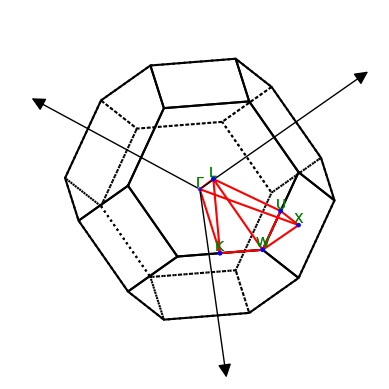

FCC(a=5.4)
  Variant name: FCC
  Special point names: GKLUWX
  Default path: GXWKGLUWLK,UX

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    K   0.3750  0.3750  0.7500
    L   0.5000  0.5000  0.5000
    U   0.6250  0.2500  0.6250
    W   0.5000  0.2500  0.7500
    X   0.5000  0.0000  0.5000

QE calculation time: 0.05 minutes (3.2 seconds)
Total energy: -310.521081 eV
Fermi energy: 6.437959 eV


In [4]:
ef_5_4_pbe, E_5_4_pbe = run_one('PBE')

In [22]:
ef_5_2_pbe, E_5_2_pbe = run_one('PBE')

QE calculation time: 0.05 minutes (3.0 seconds)
Total energy: -310.218344 eV
Fermi energy: 7.705251 eV


In [12]:
ef_4_5_pbe, E_4_5_pbe = run_one('PBE')

QE calculation time: 0.03 minutes (2.0 seconds)
Total energy: -304.473810 eV
Fermi energy: 13.944678 eV


In [14]:
ef_5_6_pbe, E_5_6_pbe = run_one('PBE')

QE calculation time: 0.06 minutes (3.3 seconds)
Total energy: -310.502858 eV
Fermi energy: 5.323035 eV


In [16]:
ef_5_8_pbe, E_5_8_pbe = run_one('PBE')

QE calculation time: 0.10 minutes (5.7 seconds)
Total energy: -310.262072 eV
Fermi energy: 4.358529 eV


In [18]:
ef_6_pbe, E_6_pbe = run_one('PBE')

QE calculation time: 0.09 minutes (5.2 seconds)
Total energy: -309.873329 eV
Fermi energy: 3.513273 eV


In [27]:
ef_5_1_pbe, E_5_1_pbe = run_one('PBE')

QE calculation time: 0.04 minutes (2.4 seconds)
Total energy: -309.908929 eV
Fermi energy: 8.416437 eV


In [31]:
ef_5_5_pbe, E_5_5_pbe = run_one('PBE')

QE calculation time: 0.05 minutes (3.2 seconds)
Total energy: -310.545344 eV
Fermi energy: 5.864824 eV


Text(0.5, 0, 'Lattice Constant (a)')

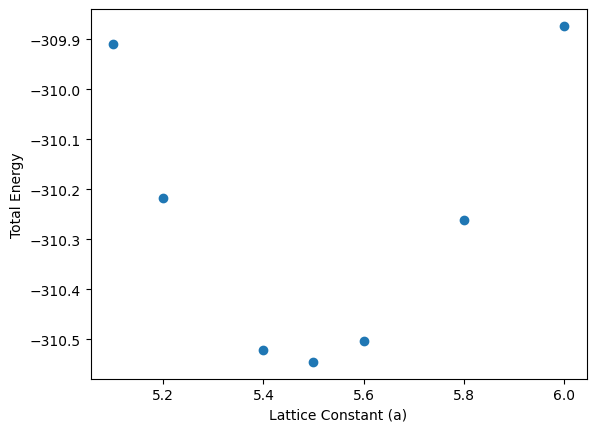

In [32]:
a = [5.1,5.2,5.4,5.5,5.6,5.8,6]
x = [i**3 for i in a]
y = [E_5_1_pbe,E_5_2_pbe,E_5_4_pbe,E_5_5_pbe,E_5_6_pbe,E_5_8_pbe,E_6_pbe]
plt.scatter(a,y)
plt.ylabel('Total Energy')
plt.xlabel('Lattice Constant (a)')

The experimental lattice constant for silicon is 5.41. These quantum calculations converge at a value slightly higher, around 5.5 A. How does this energy change if the k points are increased?

In [34]:
ef_5_5_k_8_pbe, E_5_5_k_8_pbe = run_one('PBE')

QE calculation time: 0.09 minutes (5.1 seconds)
Total energy: -310.723795 eV
Fermi energy: 5.824827 eV


In [36]:
ef_5_4_k_8_pbe, E_5_4_k_8_pbe = run_one('PBE')

QE calculation time: 0.11 minutes (6.5 seconds)
Total energy: -310.707374 eV
Fermi energy: 6.395031 eV


In [38]:
ef_5_6_k_8_pbe, E_5_6_k_8_pbe = run_one('PBE')

QE calculation time: 0.12 minutes (7.1 seconds)
Total energy: -310.674854 eV
Fermi energy: 5.286963 eV


Text(0.5, 0, 'Lattice Constant (a)')

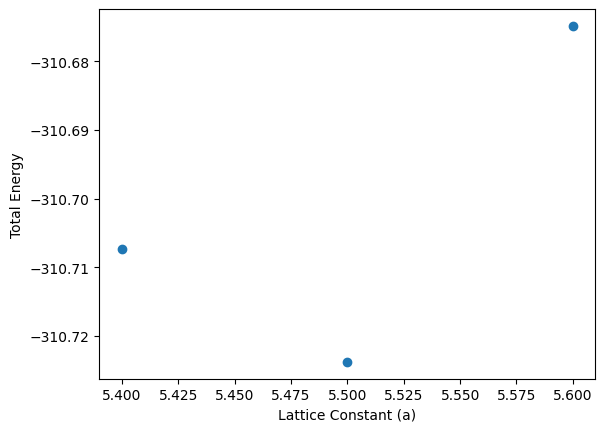

In [39]:
a = [5.4,5.5,5.6]
x = [i**3 for i in a]
y = [E_5_4_k_8_pbe,E_5_5_k_8_pbe,E_5_6_k_8_pbe]
plt.scatter(a,y)
plt.ylabel('Total Energy')
plt.xlabel('Lattice Constant (a)')

Increasing the k points from 4 to 8 resulted in a lower energy of 5.4, but 5.5 remains the lowest energy value. The reference curves for this convergence are:

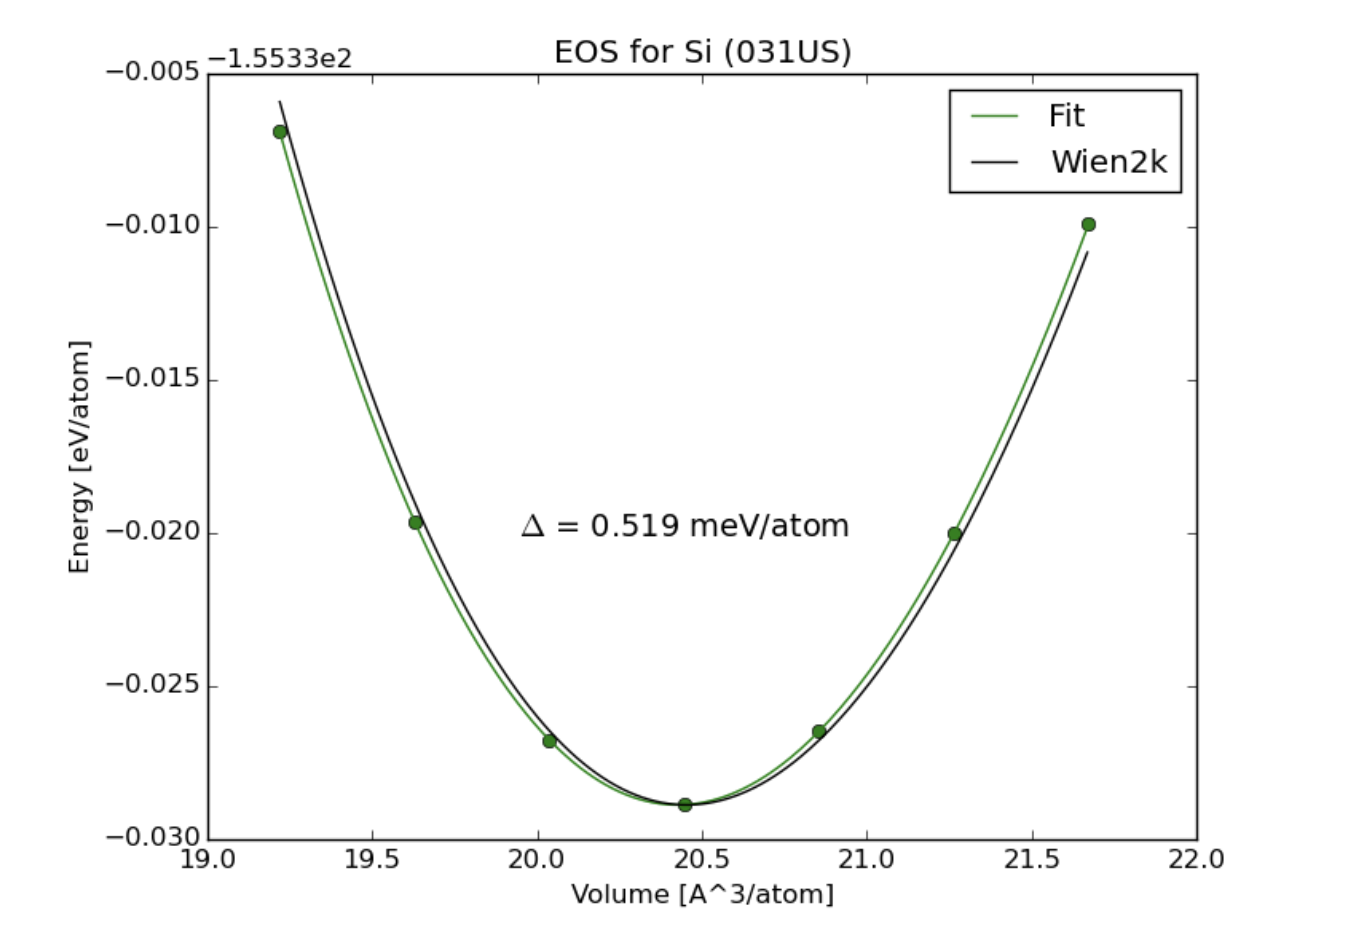

The convergence from https://legacy.materialscloud.org/discover/sssp/plot/precision/Si shows a lattice constant of approximately 5.47.

## Silicon PBESOL of diamond structure

In [ ]:
ef_5_5_pbesol, E_5_5_pbesol = run_one('PBEsol')

Both this PBEsol and another LDA pseudopotential crashed with an error about conflicting values in the potential. The PBEsol error is:

```
Error in routine set_dft_from_name (4):
      conflicting values for igcx
```
I'm unsure how to resolve these errors.


QE calculation time: 0.11 minutes (6.7 seconds)
Total energy: -310.723796 eV
Fermi energy: 5.824890 eV


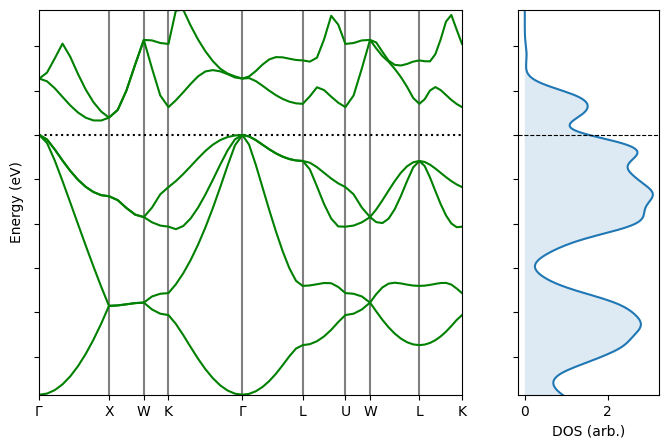

In [5]:
ef_5_5_pbe, E_5_5_pbe = run_one('PBE')

A computational source with more bands shows:

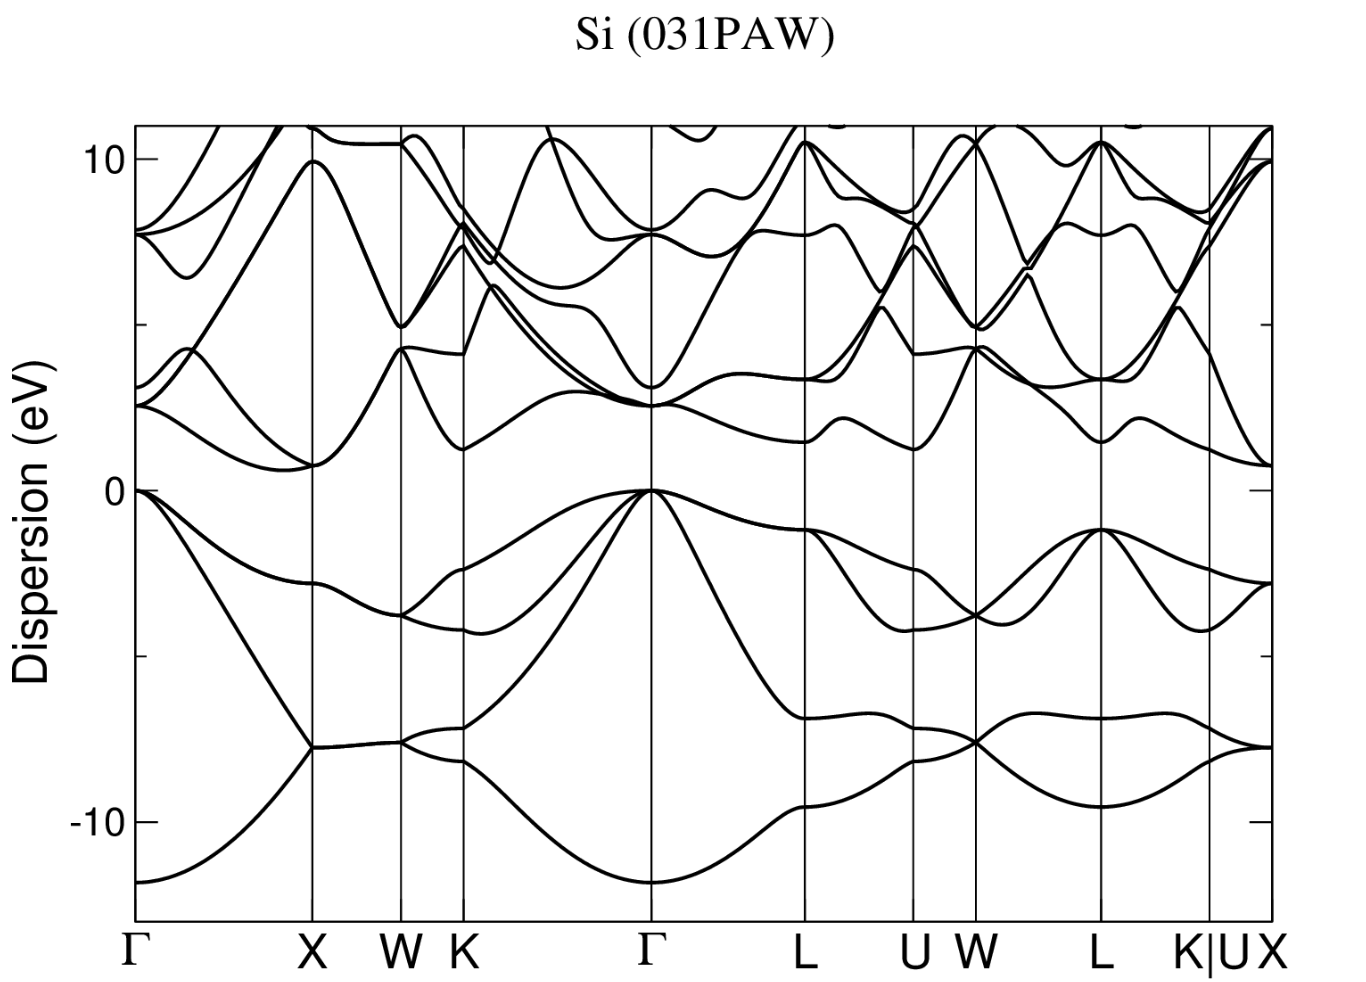

The structure looks similar, but there is not a band gap present in my results that you would expect to see for silicon.